# **Composición de los subsidios económicos**

---

Los subsidios económicos (a la energía, al transporte y a otras funciones) son -junto a las prestaciones sociales y los gastos de funcionamiento- uno de los gastos corrientes primarios más cuantiosos. Por ello, el análisis de su evolución resulta de notable importancia para la agenda económica.

El presente archivo contiene el código utilizado para obtener, procesar y analizar los datos de los montos erogados en concepto de subsidios económicos desde el año 2019.

Se elaborará una figura en forma de gráfico de barras apiladas que permita visualizar la evolución de dicho monto en igual período analizado de cada año.

Como resultado del análisis de datos, se presenta una figura en forma de gráfico de barras apiladas, que permite visualizar la evolución de los montos en períodos acumulados de cada año. La agrupación será por tipo de subsidios: subsidios a la energía, al transporte, y a otras funciones.

## Preliminar

### Importación de *libraries*

Se importan las *libraries* a utilizar en el código.

In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

### Exportación a archivo `.pdf`

En caso de precisarse exportar las figuras resultantes a formato `.pdf`, se debe instalar el *package* `kaleido`.

**IMPORTANTE**: para evitar problemas de desconexión, es recomendable ejecutar el código la siguiente celda y, una vez terminado el proceso de instalación, reiniciar el entorno de ejecución y ejecutar todas las celdas.

In [2]:
!pip install -U kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.9 MB/s eta 0:00:00


## Obtención y limpieza de datos

### Subsidios económicos

Los montos erogados por el Estado Nacional (en millones de pesos argentinos corrientes, $) en concepto de subsidios económicos son publicados mensualmente en las ejecuciones presupuestarias (Oficina Nacional de Presupuesto, ONP).

Los informes de ejecución presupuestaria a examinar son aquellos en los que se presentan datos de la Cuenta Ahorro-Inversión-Financiamiento (AIF) del Sector Público Nacional (Base Caja).

En particular, se deben extraer los datos vertidos en el Informe Mensual de Ingresos y Gastos del Sector Público Nacional No Financiero (IMIG). En él, los montos de gasto mensual en concepto de subsidios económicos se encuentran en la siguiente *ruta*:

*   Gastos Primarios
  *   Gastos corrientes primarios
     *   Subsidios económicos
         *   Energía
         *   Transporte
         *   Otras funciones

Las series mensuales (desde 2016) de estos montos son publicadas en el portal de Datos Abiertos del Gobierno Nacional (https://datos.gob.ar/) bajo el título general de "IMIG. Gastos primarios. Gastos corrientes primarios. Subsidios económicos.".

La API de Series de Tiempo del portal de Datos Argentina (Datos Abiertos de la República Argentina, https://datos.gob.ar) permite consultar indicadores con evolución en el tiempo.

La documentación de dicha API puede encontrarse en: https://datosgobar.github.io/series-tiempo-ar-api/

Para utilizarla, primeramente, se eligen los *datasets* (o series de tiempo) deseadas. Cada serie de tiempo está representada por un *id* único.

La lista `ids` contiene el *id* correspondiente a cada serie de tiempo deseada.

In [3]:
ids = ["452.2_ENERGIAGIA_0_T_7_56",
       "452.2_TRANSPORTERTE_0_T_10_32",
       "452.2_OTRAS_FUNCNES_0_T_15_25"]

Dado que la API permite efectuar consultas combinadas, evitando iteraciones innecesarias, se concatenan los elementos de la lista `ids`, separados por una coma (`,`) en una sola cadena de texto (`string`).

Así, la cadena de texto `ids` contendrá cada uno de los `id` de los *datasets* a examinar, separados por una coma.

In [4]:
ids = ",".join(map(str, ids))

Se *setea*, arbitrariamente, el comienzo del análisis en el año 2019, y se almacena en una variable llamada `start`. El formato de `start` será, también, una cadena de texto.

In [5]:
start = "2019"

A partir de los valores definidos  las cadenas de texto `ids` y en `start`, se crea una `f-string` (`url_api_call`) que funcione para hacer un *call* a la API antes mencionada.

`url_api_call` devolverá un archivo `.csv` (dado que `&format=csv`) que contiene los valores de los *datasets* identificados en `ids` a partir del año especificado en `start`.

In [6]:
url_api_call = f"https://apis.datos.gob.ar/series/api/series/?ids={ids}&start_date={start}&format=csv"

De esta manera, a partir de `url_api_call`, se puede generar el *call* a la API directamente desde un *DataFrame* creado en `pandas` con el comando `read_csv`. 

Así, se crea el *DataFrame* `subsidios`, que contiene los datos de los montos erogadso por el estado en concepto de subsidios, según tipo de subsidio, desde enero del 2019.

In [7]:
subsidios = pd.read_csv(url_api_call)

Se convierte en formato `datetime` a la columna "indice_tiempo", y se cambia el orden del día (`dayfirst=True`).

In [8]:
subsidios["indice_tiempo"] = pd.to_datetime(subsidios["indice_tiempo"], dayfirst=True)

Se crean dos columnas ("Mes" y "Año") que contienen, respectivamente, los valores del mes y año de cada dato.

In [9]:
subsidios["Mes"] = subsidios["indice_tiempo"].dt.month

In [10]:
subsidios["Año"] = subsidios["indice_tiempo"].dt.year.astype(str)

Dado que el análisis se efectúa para los primeros *n* meses del año, los meses a analizar se especifican en la lista `meses_analisis`.

In [11]:
ultimo_mes_analisis = 1
meses_analisis = list(range(1, ultimo_mes_analisis + 1))

Finalmente, se conservan solo los valores de los meses de análisis (es decir, aquellos datos en los que el valor de la columna "Mes" se encuentra en la lista `meses_analisis`.

In [12]:
subsidios = subsidios[subsidios["Mes"].isin(meses_analisis)]

### Tipo de cambio

Los montos erogados en concepto de subsidios están en $ (pesos argentinos). Dado que se los quiere expresar en US\$ (dólares estadounidenses), se debe dividir dicho valor por el tipo de cambio de cada mes.

El valor del tipo de cambio se extrae directamente de la serie del Tipo de Cambio Nominal Promedio Mensual (TCNPM), publicada por el Banco Central de la República Argentina.

In [13]:
url_tc = "https://www.bcra.gob.ar/Pdfs/PublicacionesEstadisticas/com3500.xls"

La serie de TCNPM se lee con la *library* `pandas`.

In [14]:
tc = pd.read_excel(url_tc, sheet_name="Serie de TCNPM", skiprows=1, usecols=["Mes", "Tipo de cambio nominal promedio mensual"]).drop([0]).rename(columns = {"Tipo de cambio nominal promedio mensual": "TCN"})[202:].reset_index(drop=True)

## *DataFrame* final

Se calculan los montos erogados en US\$, dividiendo cada dato según el valor del tipo de cambio.

Mediante un *for-loop*, se crean 3 columnas extra ("energia - USD", "transporte - USD" y "otras_funciones - USD") que contienen estos valores.

In [15]:
for column in subsidios.columns[1:4]:
  subsidios[column + " - USD"] = subsidios[column]/tc["TCN"]

Finalmente, se particiona el *DataFrame* (`.groupby()`) utilizando como función de agregación la suma de los montos en US\$.

In [16]:
subsidios = subsidios.groupby(["Año"], as_index=False)[subsidios.columns[-3:]].sum().reset_index(drop=True)

Por último, se crea la columna "Total", que contiene la suma de los montos erogados durante los *n* primeros meses de cada año.

In [17]:
subsidios["Total"] = subsidios[subsidios.columns[1:]].sum(axis=1)

A continuación, se presenta el *DataFrame* completo.

In [18]:
subsidios

,Año,energia - USD,transporte - USD,otras_funciones - USD,Total
0,2019,218.737720,246.200567,4.587389,469.525676
1,2020,307.460509,205.579117,3.316061,516.355687
2,2021,405.136395,214.168066,43.740433,663.044894
3,2022,589.168973,215.145320,15.674436,819.988729
4,2023,735.513523,263.166270,94.316359,1092.996152


Por último, se exporta el *DataFrame* en formato `.xlsx`.

In [19]:
subsidios.to_excel("Composición de los subsidios.xlsx", index=False)

## Figura: Composición de los subsidios (acumulado *n* meses)

La figura a elaborar consiste en un gráfico de barras apiladas en el que se visualice la evolución de los montos erogados en concepto de subsidios económicos durante los primeros *n* meses de cada año. Asimismo, se busca representar el peso de cada sector subsidiado (Energía, Transporte y Otras funciones) sobre el total gastado.

Por la complejidad del gráfico a realizar, a continuación se definen 4 funciones que logran incorporar cada uno de los elementos presentes del gráfico deseado.

Primeramente, se crea la función `bar_creator`, que consiste en un *for-loop* conjunto entre: 

1.   cada una de las columnas a visualizar
2.   el nombre asignado a cada una de esas columnas
3.   el color asignado a cada una de esas columnas


Los parámetros de la función son:
*   `df`: el nombre del dataframe del cual extraer los datos.
*   `fig`: el nombre de la figura a utilizar.
*   `nombres_list`: lista que contiene los nombres de cada uno de los tipos de subsidios.
*   `colores_list`: lista que contiene los colores de cada uno de los tipos de subsidios.

Fuera del *for-loop*, se agrega una traza (`trace`) "fantasma", con color transparente, que permite mostrar los montos totales erogados en cada año.

In [20]:
def bar_creator(df, fig, nombres_list, colores_list):
  for column, nombre, color in zip(df.columns[1:-1], nombres_list, colores_list):
    fig.add_trace(
      go.Bar(
        x = df["Año"],
        y = df[column],
        name = nombre,
        text = df[column],
        textposition = "inside",
        texttemplate = "%{value:,.2f}",
        marker = dict(
            color = color
            )
        )
    )
  fig.add_trace(
    go.Bar(
      name="Total",
      x = df["Año"],
      y = [0]*len(df),
      showlegend = False,
      text = df["Total"],
      textposition = "outside",
      textfont = dict(
        size=18
      ),
      texttemplate = "%{text:,.2f}",
      marker = dict(
        color = "rgba(0,0,0,0)"
      )
      )
  )

Luego, se crea la función `adding_annotation`, que permite crear anotaciones para visualizar el porcentaje de crecimiento del monto total erogado en el acumulado de *n* meses.

Los parámetros de la función son:
*   `df`: el nombre del dataframe del cual extraer los datos.
*   `fig`: el nombre de la figura a utilizar.
*   `heigths`: lista que contiene las alturas sobre el eje de las ordenadas sobre las que se ubicarán las anotaciones.

In [21]:
def adding_annotation(df, fig, heights):
  for i, height in zip(range(1, len(df)), heights):
    fig.add_annotation(
      x = i - 0.5,
      y = height,
      text = f"<b>+{(df['Total'][i]/df['Total'][i-1]-1)*100:.0f}%",
      font = dict(
          size = 18
      ),
      bgcolor = "rgba(255,255,255,1)",
      showarrow = False)

Equivalentemente, se crea la función `adding_lines`, que permite crear flechas para ayudar a la correcta visualización de las anotaciones definidas en `adding_annotations`.

Los parámetros de la función son:
*   `fig`: el nombre de la figura a utilizar.
*   `tuple_x`: 4-tupla que los valores del eje de abscisas de origen, máximo y destino.
*   `tuple_y`: 4-tupla que los valores del eje de ordenadas de origen, máximo y destino.

In [22]:
def adding_lines(fig, tuple_x, tuple_y):
  fig.add_trace(go.Scatter(
    x = tuple_x,
    y = tuple_y,
    mode = "lines+markers",
    line = dict(
      color = "black",
      width = 1
    ),
    marker = dict(
      size = [0]*3 + [10],
      opacity = 1,
      symbol = ["circle"]*3 + ["arrow-down"]
    ),
    showlegend=False
    )
  )

Por último, se crea la función `update_layout`, que modifica el aspecto general de la figura.

El único parámetro de la función es:
*   `fig`: el nombre de la figura a utilizar

In [23]:
def update_layout(fig):
  fig.update_layout(
    plot_bgcolor = "rgba(0,0,0,0)",
    margin = dict(
        b = 15,
        t = 15,
        l = 15,
        r = 15
    ),
    barmode = "stack",
    legend = dict(
      traceorder = "normal",
      orientation = "h",
      xanchor = "center", 
      x = 0.5, 
      yanchor = "bottom", 
      y = 1,
      font = dict(
        size = 16
      )
    ),
    height = 750,
    width = 1000,
    xaxis = dict(
      tickformat = "%Y",
      dtick = "M12",
      title_text = f"Acumulado {ultimo_mes_analisis} mes(es)"
    ),
    yaxis = dict(
      title="<b>M USD",
      range=[0, round(max(subsidios["Total"]), -2)*1.2 ],
      dtick = round(subsidios["Total"][1]/subsidios["Total"][0], -2),
      showgrid = True,
      gridcolor = "lightgray"
    ),
    font = dict(
      size = 14,
      family="serif"
    )
  )

Una vez definidas las funciones, se especifican los correspondientes valores de los parámetros antes nombrados.

En particular, las listas `nombres` y `colores` contendrán los valores especificados para las listas `nombres_list` y `colores_list` de la función `bar_creator`.

In [24]:
nombres = ["Subsidios a la energía", "Subsidios al transporte", "Otros subsidios"]

In [25]:
colores = ["rgb(252,141,98)", "rgb(102,194,165)", "rgb(255,217,47)"]

3.   Las anotaciones indicando el porcentaje de crecimiento del monto total erogado se encuentran en las alturas del eje de ordenadas definidas en `heights`.

Las alturas de las anotaciones indicando el porcentaje de crecimiento del monto total erogado entre cada año (en la función `adding_annotation`) se definen en la lista `heights`.

In [26]:
heights = []
for i in range(1, len(subsidios)):
  heights.append(round(subsidios["Total"][i]*1.175, -1))

Las dos 4-tuplas, `tuples_x` y `tuples_y` correspondientes a la función `adding_lines` se construyen a continuación, a partir de los datos del *DataFrame* `subsidios` y la lista `heights`.

In [27]:
tuples_x = []
for i in range(0, len(subsidios)-1):
  tuples_x.append([int(subsidios["Año"][i]),
                   int(subsidios["Año"][i]),
                   int(subsidios["Año"][i+1]),
                   int(subsidios["Año"][i+1])])

In [28]:
tuples_y = []
for i, height in zip(range(0, len(subsidios)-1), heights):
  if i != 3:
    tuples_y.append([subsidios["Total"][i]*1.1,
                   height,
                   height,
                   subsidios["Total"][i+1]*1.1])
  else: 
    tuples_y.append([subsidios["Total"][i]*1.1,
                   height,
                   height,
                   subsidios["Total"][i+1]*1.05])

Se crea la figura `subsidios_fig` en el entorno de Plotly (utilizando `graph_objects` como `go`).

In [29]:
subsidios_fig = go.Figure()

Mediante las funciones antes especificadas (a saber: `bar_creator`, `adding_annotation`, `adding_lines` y `update_layout`) se introducen los datos y se modifica el aspecto de la figura en general.

In [30]:
bar_creator(subsidios, subsidios_fig, nombres, colores)

adding_annotation(subsidios, subsidios_fig, heights)

for i in range(0, len(subsidios)-1): 
  adding_lines(subsidios_fig,tuples_x[i], tuples_y[i])

update_layout(subsidios_fig)

A continuación, se exhibe la figura.

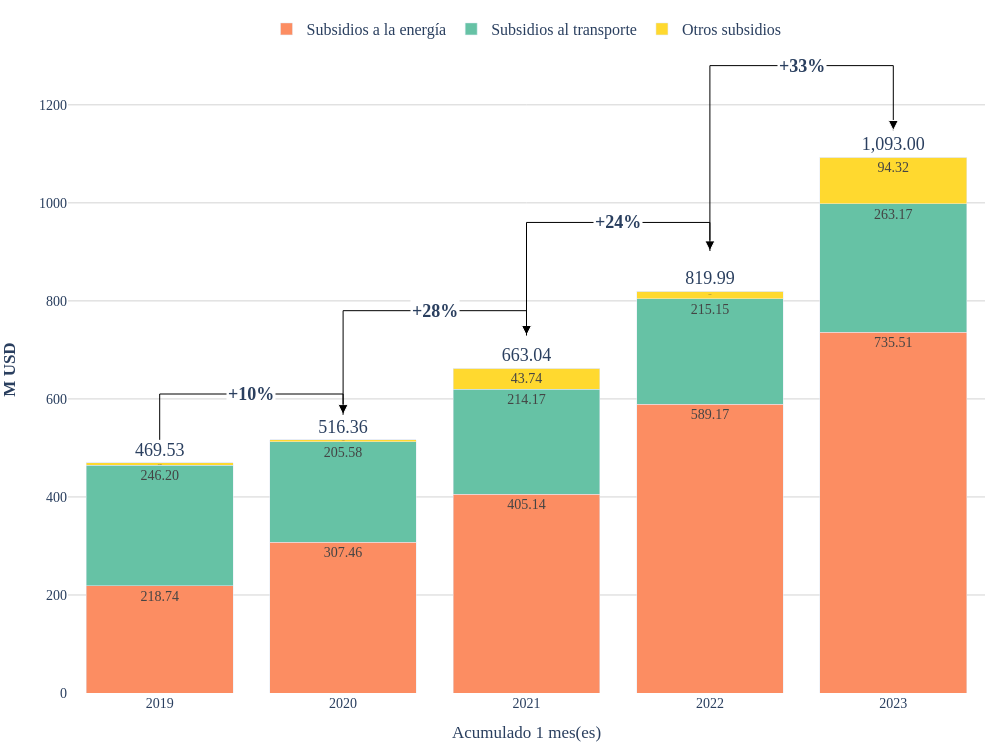

In [31]:
subsidios_fig.show("png")

Si se desea exportar la figura a formato `.pdf`, se debe des-comentar y ejecutar la siguiente celda. Recuérdese que el *package* `kaleido` debe estar correctamente instalado.

In [32]:
pio.write_image(subsidios_fig, "Figura Subsidios.pdf", width=3*300, height=2.25*300)